# train LG2 : LG trained on imbalanced ClinVar data with 12 features

Method:  
1.  C=10,
2. boundary plot
3. LG2 and preprocessor2


12 features :

CADD,
Frq,
GNOMADAF_popmax,
Consequence,
BIOTYPE,
PolyPhen,
REVEL_score,
pLI_gene_value,
SpliceAI_pred_DS_AG,
SpliceAI_pred_DS_AL,
SpliceAI_pred_DS_DG,
SpliceAI_pred_DS_DL

In [1]:
import gzip
import pandas as pd
import numpy as np
from joblib import dump, load

import matplotlib.pyplot as plt



from sklearn.compose import make_column_transformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer



from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

/Users/nancy/miniconda3/envs/bioinfo/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##  preprocessing

In [2]:
df = pd.read_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_train_model/01_featureV1/01_ALLfeatures_extracted_addCLNSIG.csv',sep=';',index_col=False)
df

/var/folders/q0/2p8kfxsn7s73349btf1_g07h0000gp/T/ipykernel_57754/3969921985.py:1: DtypeWarning: Columns (32,49,50,51,54,56,58,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_train_model/01_featureV1/01_ALLfeatures_extracted_addCLNSIG.csv',sep=';',index_col=False)


,CLNSIG,CADD,AF_ESP,AF_EXAC,AF_TGP,Frq,GNOMADAF,GNOMADAF_popmax,Hom,ORIGIN,...,SpliceAI_pred_DP_AG,SpliceAI_pred_DP_AL,SpliceAI_pred_DP_DG,SpliceAI_pred_DP_DL,SpliceAI_pred_DS_AG,SpliceAI_pred_DS_AL,SpliceAI_pred_DS_DG,SpliceAI_pred_DS_DL,SpliceAI_pred_SYMBOL,genomic_superdups_frac_match
0,Uncertain_significance,26.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-30.0,11.0,10.0,-30.0,0.01,0.00,0.09,0.00,SAMD11,NaN
1,Likely_benign,13.420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,7.0,-34.0,6.0,42.0,0.00,0.02,0.03,0.00,SAMD11,NaN
2,Likely_benign,31.000,NaN,NaN,NaN,0.00056,0.000414,0.000195,NaN,1.0,...,41.0,-47.0,-7.0,44.0,0.00,0.01,0.06,0.00,SAMD11,NaN
3,Uncertain_significance,28.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,10.0,-47.0,34.0,-14.0,0.00,0.00,0.03,0.02,SAMD11,NaN
4,Likely_benign,11.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,-35.0,-50.0,12.0,24.0,0.00,0.00,0.01,0.00,SAMD11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468907,Benign,7.587,NaN,NaN,NaN,0.00070,NaN,NaN,5.0,1.0,...,25.0,35.0,0.0,16.0,0.00,0.00,0.00,0.00,USP9Y,NaN
1468908,Uncertain_significance,23.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1468909,Benign,11.200,0.00614,0.00589,0.00243,0.00671,NaN,NaN,48.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1468910,Uncertain_significance,21.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
""" 1. choose featuresV1"""

featureV1 = ['CLNSIG',
'CADD',
'Frq',
'GNOMADAF_popmax',
'Consequence',
'BIOTYPE',
'PolyPhen',
'REVEL_score',
'pLI_gene_value',
'SpliceAI_pred_DS_AG',
'SpliceAI_pred_DS_AL',
'SpliceAI_pred_DS_DG',
'SpliceAI_pred_DS_DL']         # keep CLNSIG,

df_1 = df[featureV1]



""" 2. only remove missing target """

drop_nan_features = ['CLNSIG']
df_1 = df_1.dropna(subset=drop_nan_features)

In [4]:
# """  CLNSIG: tansfer to 4 classes__ benign,pathogenic,uncertain,others
# NOTE:
# (only count name before |)   explanation-- https://www.ncbi.nlm.nih.gov/clinvar/docs/clinsig/#clinsig_scv

# 1. pathogenic: Pathogenic, Pathogenic/Likely_pathogenic, Likely_pathogenic
# 2. benign: Likely_benign, Benign, Benign/Likely_benign
# 3. uncertain: Uncertain_significance, 
# 4. others: Uncertain_risk_allele, risk_factor, protective, other, not_provided, Likely_risk_allele, drug_response, Conflicting_interpretations_of_pathogenicity, confers_sensitivity, associatio, Affects

df_1 = df_1.copy()
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Uncertain_significance|_risk_factor', 'Uncertain_significance|_other', 'Uncertain_significance|_drug_response','Uncertain_significance|_association','Uncertain_significance|_Affects','Uncertain_significance'], 'uncertain')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Pathogenic|_risk_factor','Pathogenic|_protective','Pathogenic|_other','Pathogenic|_drug_response|_other','Pathogenic|_drug_response','Pathogenic|_confers_sensitivity','Pathogenic|_association','Pathogenic|_Affects','Pathogenic/Likely_risk_allele','Pathogenic/Likely_pathogenic|_risk_factor','Pathogenic/Likely_pathogenic|_other','Pathogenic/Likely_pathogenic|_drug_response','Pathogenic/Likely_pathogenic','Pathogenic','Likely_pathogenic|_risk_factor','Likely_pathogenic|_other','Likely_pathogenic|_drug_response','Likely_pathogenic|_association','Likely_pathogenic|_Affects','Likely_pathogenic,_low_penetrance','Likely_pathogenic'], 'pathogenic')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Likely_benign|_risk_factor','Likely_benign|_other','Likely_benign|_drug_response|_other','Likely_benign','Benign|_risk_factor','Benign|_protective','Benign|_other','Benign|_drug_response','Benign|_confers_sensitivity','Benign|_association|_confers_sensitivity','Benign|_association','Benign/Likely_benign|_risk_factor','Benign/Likely_benign|_other|_risk_factor','Benign/Likely_benign|_other','Benign/Likely_benign|_drug_response|_other','Benign/Likely_benign|_drug_response','Benign/Likely_benign|_association','Benign/Likely_benign','Benign'], 'benign')
df_1['CLNSIG'] = df_1['CLNSIG'].replace(['Uncertain_risk_allele|_risk_factor','Uncertain_risk_allele','risk_factor','protective','protective|_risk_factor','other', 'not_provided','Likely_risk_allele','drug_response|_risk_factor','drug_response|_other','drug_response','Conflicting_interpretations_of_pathogenicity|_risk_factor','Conflicting_interpretations_of_pathogenicity|_protective','Conflicting_interpretations_of_pathogenicity|_other|_risk_factor','Conflicting_interpretations_of_pathogenicity|_other','Conflicting_interpretations_of_pathogenicity|_drug_response|_other','Conflicting_interpretations_of_pathogenicity|_drug_response','Conflicting_interpretations_of_pathogenicity|_association|_risk_factor','Conflicting_interpretations_of_pathogenicity|_association','Conflicting_interpretations_of_pathogenicity','confers_sensitivity','association|_risk_factor','association_not_found','association','Affects|_risk_factor','Affects|_association','Affects'], 'others')

# only keep benign & pathogenic
df_1 = df_1.loc[df_1['CLNSIG'].isin(['benign','pathogenic'])]

# label encoder
map_clnsig={'pathogenic':1,'benign':0}
df_1['CLNSIG']=df_1['CLNSIG'].map(lambda s: map_clnsig.get(s) if s in map_clnsig else s)
# df_1["CLNSIG"].unique()

In [5]:
"""4.2  keep imbalance classes """

# split
from sklearn.model_selection import train_test_split

X, y = df_1.iloc[:, 1:], df_1.iloc[:, 0]
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                    test_size=0.3,
                    random_state=42,
                    stratify=y)

In [6]:
""" 5. features engineering: transformer"""
## only for training data, no care about target 'CLNSIG', total 29 features


# ## numerical feature group 1 : replace missing with mean;  scaling/standardization

# numeric_feature_1 = ['MES-SWA_acceptor_alt','MES-SWA_acceptor_diff','MES-SWA_donor_alt','MES-SWA_donor_diff','MaxEntScan_alt','MaxEntScan_diff','GERP++_RS',
#     'phastCons100way_vertebrate','phyloP100way_vertebrate']



## numerical feature group 2 : replace missing with 0;  scaling/standardization
numeric_feature_2 = ['CADD','Frq', 'GNOMADAF_popmax','pLI_gene_value','SpliceAI_pred_DS_AL',
       'SpliceAI_pred_DS_DG','SpliceAI_pred_DS_DL']



## numerical feature group 3: add missing indicator; replace missing with 0 and ; scaling/standardization
numeric_feature_3 = ['REVEL_score','SpliceAI_pred_DS_AG']



## categorical ordinal feature group 4: add missing indicator for ['PolyPhen']; replace missing with 'missing_value' string; OrdinalEncoder
categori_oridinal_feature_4 =['Consequence','PolyPhen']

# ordinal features' order: left to right will be from 0 to length-1
with open('variant_consequences.txt','r') as f:             # get the 'variant_consequences order' lst: descending severity
    order_conseq=[line.rstrip("\n") for line in f] 
    order_conseq.reverse()

ordinal_features = [
    'Consequence',
    'IMPACT',
    'SIFT',
    'PolyPhen']
# 0 is the missing value will be replaced by
ordinal_ordering = [
    order_conseq,
    ['unknown','benign','possibly_damaging','probably_damaging']
    ]


## categorical nominal feature group 5: replace missing with ''missing_value' in ['BIOTYPE'];  BinaryEncoder
categori_nominal_feature_5 = ['BIOTYPE']  #,'BIOTYPE'



# numeric_feature_1_transformer =make_pipeline(
#     SimpleImputer(strategy='mean'),
#     StandardScaler()
# )

numeric_feature_2_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=0),
    StandardScaler()
)

numeric_feature_3_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=0),
    StandardScaler()
)

categori_oridinal_feature_4_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=None),  # If None, fill_value will be 0 when imputing numerical data and “missing_value” for strings
    OrdinalEncoder(categories=ordinal_ordering, handle_unknown='use_encoded_value', unknown_value = -1)       # the unknown 'missing_value' string will be enocoded as '-1'
)

categori_oridinal_feature_5_transformer =make_pipeline(
    SimpleImputer(strategy='constant',fill_value=None),  
    BinaryEncoder()                                # add new columns, throw the original columns automaticly, 
)


preprocessor = make_column_transformer(
    # (numeric_feature_1_transformer, numeric_feature_1),
    (numeric_feature_2_transformer, numeric_feature_2 ),
    (MissingIndicator(), numeric_feature_3 + categori_oridinal_feature_4[1:]),   # add new missing indicators for feature3 + ['PolyPhen'] without originial columns,  here: total add 3 indicator columns
    (numeric_feature_3_transformer, numeric_feature_3),  
    (categori_oridinal_feature_4_transformer, categori_oridinal_feature_4),
    (categori_oridinal_feature_5_transformer, categori_nominal_feature_5),                                                    
    # (categori_oridinal_feature_5_transformer, categori_nominal_feature_5[1:])   # for checking: how many ori and biotype derived features seperately; must use [1:] formate, and see the `'BIOTYPE` first, and then can get `origin`
    # remainder='passthrough'                                                   # so here for `BIOTYPE` derived new: 5  
)



### check the features names and number after preprocessing

In [7]:
# steps before  5_transformer   : 14 output

col1 = numeric_feature_2
col2 = ['miss_REVEL_score', 'miss_SpliceAI_pred_DS_AG','miss_PolyPhen']
col3 = numeric_feature_3 + categori_oridinal_feature_4
# col4 = ['BIOTYPE_0','BIOTYPE_1','BIOTYPE_2','BIOTYPE_3','BIOTYPE_4']
cols = col1 + col2 + col3      ## get all columns's names after preprocessing
len(cols)


14

In [9]:
## after all steps: tatol 19 ouputs,  so  derived BIOTYPE should have 19-14 = 5 
check_X_pre = preprocessor.fit_transform(X_train)  

pd.DataFrame(check_X_pre)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.628250,-0.301363,-0.324323,-0.746422,-0.186852,-0.158708,-0.183501,0.0,0.0,0.0,2.470525,-0.183280,28.0,3.0,0.0,0.0,0.0,0.0,1.0
1,-0.142574,-0.301363,-0.324323,-0.746422,-0.186852,-0.158708,-0.183501,1.0,0.0,1.0,-0.306583,-0.183280,19.0,-1.0,0.0,0.0,0.0,0.0,1.0
2,-0.789858,2.968318,0.558300,-0.746422,-0.186852,-0.158708,-0.183501,1.0,0.0,1.0,-0.306583,-0.183280,19.0,-1.0,0.0,0.0,0.0,0.0,1.0
3,-1.022955,-0.241268,0.031418,-0.746422,-0.100617,-0.158708,-0.183501,1.0,0.0,1.0,-0.306583,-0.183280,13.0,-1.0,0.0,0.0,0.0,0.0,1.0
4,1.150801,-0.301363,-0.324323,-0.746422,-0.186852,-0.158708,-0.183501,1.0,1.0,1.0,-0.306583,-0.183280,34.0,-1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553591,0.415871,-0.011976,0.184291,1.263693,-0.186852,-0.007497,-0.183501,1.0,0.0,1.0,-0.306583,-0.060192,16.0,-1.0,0.0,0.0,0.0,0.0,1.0
553592,-0.141721,-0.299046,-0.311996,-0.746422,-0.186852,-0.158708,-0.183501,1.0,0.0,1.0,-0.306583,-0.183280,19.0,-1.0,0.0,0.0,0.0,0.0,1.0
553593,-1.044526,-0.301363,-0.324323,-0.746422,-0.186852,-0.158708,-0.183501,1.0,0.0,1.0,-0.306583,0.432158,19.0,-1.0,0.0,0.0,0.0,0.0,1.0
553594,0.095298,-0.301363,-0.324323,-0.746422,-0.186852,-0.007497,-0.183501,1.0,0.0,1.0,-0.306583,-0.183280,26.0,-1.0,0.0,0.0,0.0,0.0,1.0


In [8]:
## final features names: after preprocessing

col4 = ['BIOTYPE_0','BIOTYPE_1','BIOTYPE_2','BIOTYPE_3','BIOTYPE_4']
cols = col1 + col2 + col3 + col4
len(cols)

19

In [9]:
cols

['CADD',
 'Frq',
 'GNOMADAF_popmax',
 'pLI_gene_value',
 'SpliceAI_pred_DS_AL',
 'SpliceAI_pred_DS_DG',
 'SpliceAI_pred_DS_DL',
 'miss_REVEL_score',
 'miss_SpliceAI_pred_DS_AG',
 'miss_PolyPhen',
 'REVEL_score',
 'SpliceAI_pred_DS_AG',
 'Consequence',
 'PolyPhen',
 'BIOTYPE_0',
 'BIOTYPE_1',
 'BIOTYPE_2',
 'BIOTYPE_3',
 'BIOTYPE_4']

## train 
C =10 from before grid search

In [11]:
## fit and real test score
lr = LogisticRegression(max_iter=2000, C=10, random_state= 42)

pipeline = make_pipeline(preprocessor, lr) 
pipeline.fit(X_train, y_train)              # preprocessor and lr both fitted by X_train here!

print(f"accurate on test set: {pipeline.score(X_train, y_train):.4f}")
print(f"accurate on test set: {pipeline.score(X_test, y_test):.4f}")

accurate on test set: 0.9783
accurate on test set: 0.9783


In [12]:
# save
dump(lr,'/Users/nancy/Desktop/RS_projects/result/03_ML/01_train_model/02_featureV2/02_12feats_clinvar_LG.joblib')

dump(preprocessor,'/Users/nancy/Desktop/RS_projects/result/03_ML/01_train_model/02_featureV2/02_12feats_clinvar_preprocessor.joblib')

['/Users/nancy/Desktop/RS_projects/result/03_ML/01_train_model/02_featureV2/02_12feats_clinvar_preprocessor.joblib']

In [15]:
preprocessor.transform(X)

array([[ 0.04414298, -0.30136346, -0.32432339, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.54299172, -0.29209246, -0.32245306, ...,  0.        ,
         0.        ,  1.        ],
       [-0.12978486, -0.30136346, -0.32432339, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.45317129, -0.28977471, -0.32432339, ...,  0.        ,
         0.        ,  1.        ],
       [-0.14513144, -0.19027707, -0.32432339, ...,  0.        ,
         0.        ,  1.        ],
       [-0.6449182 ,  0.11748684, -0.32432339, ...,  0.        ,
         0.        ,  1.        ]])

### boundary decision plot

In [13]:
# since a lot of features,  we need to PCA reduce features dimensions to 2
from sklearn.decomposition import PCA

# need preprocessd features data
preprocessed_features_X_train = preprocessor.fit_transform(X_train) 
preprocessed_features_X_test = preprocessor.transform(X_test) 

## PCA
pca_fitted = PCA(n_components=2).fit(preprocessed_features_X_train)

X_2d = pca_fitted.transform(preprocessed_features_X_train)
X_T_2d = pca_fitted.transform(preprocessed_features_X_test)


# retrain LG by  PCA reduced data

logreg = LogisticRegression(max_iter=2000, C=10, random_state= 42).fit(X_2d, y_train)   # max iteration to finish converage: max_iter=1000

print("Training set score: {:.3f}".format(logreg.score(X_2d, y_train))) 
print("Test set score: {:.3f}".format(logreg.score(X_T_2d, y_test)))


KeyboardInterrupt: 

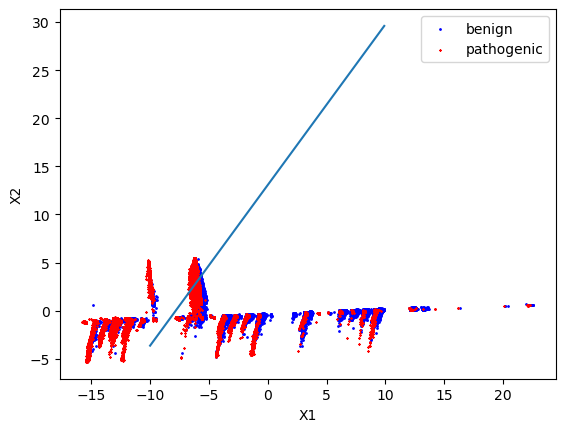

In [ ]:
# boundary decision plot: for regression model

coef = np.array(logreg.coef_)
x1_plot = np.arange(-10,10,step=0.1)
x2_plot = -(x1_plot * coef[0][0] + logreg.intercept_)/coef[0][1]
plt.plot(x1_plot, x2_plot)
plt.scatter(X_2d[y_train==0,0],X_2d[y_train==0,1],s=1,c='b',marker='o',label='benign') ##  0
plt.scatter(X_2d[y_train==1,0],X_2d[y_train==1,1],s=1,c='r',marker='x',label='pathogenic') ## 1
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
# plt.title('Decision Boundaray')
plt.show()